<a href="https://colab.research.google.com/github/ProshkinNV/Image/blob/main/GitHub_Autoencoder_%E2%84%963.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импорт библиотек

In [ ]:
import numpy as np # Работа с массивами данных
import matplotlib.pyplot as plt # Графики
%matplotlib inline
import keras
from keras import utils # Утилиты
from keras.models import Model # Конструктор модели
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, UpSampling2D, Conv2DTranspose, BatchNormalization # Слои
from keras.optimizers import Adam # Оптимизатор
from keras.callbacks import EarlyStopping # Коллбэки
import cv2 # Opencv для работы с изображениями
import os # Системный команды
import tensorflow as tf # Аугментация
from sklearn.model_selection import train_test_split # Расщипление выборок
#библиотека для нанесение водных знаков
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
#библиотеки для генерации текста
from string import ascii_lowercase, ascii_uppercase, digits
from random import choice, choices, randint
#Для удаления папок с файлами
import shutil

Загрузка Датасэта и работа с файловой системой

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/watermarked.zip
!unzip -qo "watermarked.zip" -d ./watermarked

--2024-08-02 07:53:00--  https://storage.yandexcloud.net/academy.ai/watermarked.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 731796045 (698M) [application/x-zip-compressed]
Saving to: ‘watermarked.zip’

watermarked.zip     100%[===================>] 697.89M  75.0MB/s    in 13s     

2024-08-02 07:53:14 (52.8 MB/s) - ‘watermarked.zip’ saved [731796045/731796045]



In [ ]:
#путь до файлов без водного знака
PATH_TRAIN_FILES ='/content/watermarked/wm-nowm/train/no-watermark'
PATH_VALID_FILES ='/content/watermarked/wm-nowm/valid/no-watermark'

#Пути до папок с водным знаком
PATH_TRAIN_FILES_WM = '/content/watermarked/wm-nowm/train/watermark'
PATH_VALID_FILES_WM = '/content/watermarked/wm-nowm/valid/watermark'

#путь до X_train / Y_train
PATH_X_TRAIN = '/content/watermarked/wm-nowm/train/X_train'
PATH_Y_TRAIN = '/content/watermarked/wm-nowm/train/Y_train'

#путь до X_test / Y_test
PATH_X_TEST = '/content/watermarked/wm-nowm/valid/X_test'
PATH_Y_TEST = '/content/watermarked/wm-nowm/valid/Y_test'


try:
  #Удаляем папки с ВМ
  shutil.rmtree(PATH_TRAIN_FILES_WM)
  shutil.rmtree(PATH_VALID_FILES_WM)

  del PATH_TRAIN_FILES_WM,PATH_VALID_FILES_WM

  #Создаем папки X... / Y... для хранения выборок
  os.mkdir(PATH_X_TRAIN)
  os.mkdir(PATH_Y_TRAIN)
  #
  os.mkdir(PATH_X_TEST)
  os.mkdir(PATH_Y_TEST)

except Exception as e:
  print(f"Ошибка с удалением / созданием папок: {e}")


try:
  FILES_Y_TRAIN = os.listdir(PATH_TRAIN_FILES)
  FILES_Y_TEST = os.listdir(PATH_VALID_FILES)

  print(f"Кол-во файлов без водного знака для тренировочной выборки: {len(FILES_Y_TRAIN)}")
  print(f"Кол-во файлов без водного знака для контрольной выборки: {len(FILES_Y_TEST)}")

  #Ограничиваем количество данных для экономии ресурсов
  FILES_Y_TRAIN = FILES_Y_TRAIN[:4000]
  FILES_Y_TEST = FILES_Y_TEST[:1000]
except Exception as e:
  print(f"Наверный путь до данных: {e}")

Кол-во файлов без водного знака для тренировочной выборки: 12477
Кол-во файлов без водного знака для контрольной выборки: 3289


Вспомогательные функции

In [ ]:
#Фун-я изменение размера изображения
def Resize_Img(old_path,files,new_path):
  for file_name in files:
    image = os.path.join(old_path,file_name)
    try:
      with Image.open(image) as temp_image:
        #Изменение размера изображения
        temp_image = temp_image.resize((100,100))
        path_out = new_path + '/' + file_name
        temp_image.save(path_out)
    except Exception as e:
      print(f"Ошибка : {e}")
      print(f"Название файла: {image}")

#Словарь
letters_and_digits = ascii_lowercase + digits

#Фун-я генерации текста
def Generate_Text():
  text = choice(ascii_uppercase)
  text += ''.join(choices(letters_and_digits, k=7))
  return text

#Фун-я маркировки
def Watermark(old_path,files,new_path):
  for file_name in files:
    image = os.path.join(old_path,file_name)
    try:
      with Image.open(image) as temp_image:
        draw = ImageDraw.Draw(temp_image)
        black = (3,8,12)
        text = Generate_Text()
        pos = (0,randint(10, 80))
        font = ImageFont.truetype(font="/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf",size=40)
        draw.text(pos, text, fill=black, font=font)
        path_out = new_path + '/' + file_name
        temp_image.save(path_out)
    except Exception as e:
      print(f"Ошибка : {e}")
      print(f"Название файла: {image}")

# Функция загрузки
def Сreate_Pixel_Arr(files):
  data = []
  for image in files:
    try:
      # Загрузим изображение в матрицу (сохранив цвета, загружает как BGR)
      img_arr = cv2.imread(image, cv2.IMREAD_COLOR)
      data.append(img_arr) # добавляем в список матрицу пикселей картинки
    except Exception as e:
      print(f"Ошибка формирования массива матрицы пиксилей: {e}")
  return np.array(data) # возвращаем набор картинок как матрицу

#Функция получения массива путей к файлам
def Path_To_Image(path,name):
  data = []
  for item in name:
    temp = os.path.join(path,item)
    data.append(temp)
  return data

Изменяем размер изображений и сохраняем в Y_train / Y_test

In [ ]:
Resize_Img(PATH_TRAIN_FILES, FILES_Y_TRAIN, PATH_Y_TRAIN)
Resize_Img(PATH_VALID_FILES, FILES_Y_TEST, PATH_Y_TEST)

Добавление водяного знака в виде текста

In [ ]:
Watermark(PATH_Y_TRAIN, FILES_Y_TRAIN, PATH_X_TRAIN)
Watermark(PATH_Y_TEST, FILES_Y_TEST, PATH_X_TEST)

Создания массива адресов для выборок

In [ ]:
y_train = Path_To_Image(PATH_Y_TRAIN, FILES_Y_TRAIN)
x_train = Path_To_Image(PATH_X_TRAIN, FILES_Y_TRAIN)
#
y_test = Path_To_Image(PATH_Y_TEST, FILES_Y_TEST)
x_test = Path_To_Image(PATH_X_TEST, FILES_Y_TEST)

Подготовка данных

In [ ]:
y_train = Сreate_Pixel_Arr(y_train)
x_train = Сreate_Pixel_Arr(x_train)
#
y_test = Сreate_Pixel_Arr(y_test)
x_test = Сreate_Pixel_Arr(x_test)

Нормализация данных

In [ ]:
x_train = x_train.astype('float32') / 255.
y_train = y_train.astype('float32') / 255.
#
x_test = x_test.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.

Создание модели

In [ ]:
def create_model(img_x, img_y, channel):
    inputs = Input(shape=(img_x, img_y, channel))

    # Кодировщик - сжимает входные данные в латентное пространство
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    h = MaxPooling2D((2, 2), padding='same')(x)

    # Декодировщик - реконструирует сжатое представление
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(h)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)

    outputs = Conv2D(channel, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse',  metrics=['acc'])
    return model

In [ ]:
watermark_auto_encoder = create_model(100, 100, 3)

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=6, restore_best_weights=True)
history = watermark_auto_encoder.fit(x_train, y_train, batch_size=64, epochs=100, callbacks=[early_stop])

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - acc: 0.4255 - loss: 0.0580
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - acc: 0.6023 - loss: 0.0222
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - acc: 0.6209 - loss: 0.0187
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - acc: 0.6187 - loss: 0.0167
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - acc: 0.6283 - loss: 0.0158
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - acc: 0.6365 - loss: 0.0152
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - acc: 0.6409 - loss: 0.0146
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - acc: 0.6392 - loss: 0.0142
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - acc: 0.6523 - loss: 0.0136
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - acc: 0.6531 - loss: 0.0136
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - acc: 0.6689 - loss: 0.0131
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - acc: 0.6751 - loss: 0.0130
Epoch 13/100
63/63 ━━━━

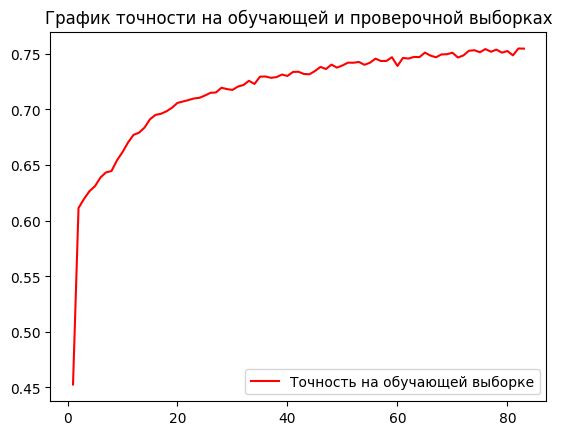

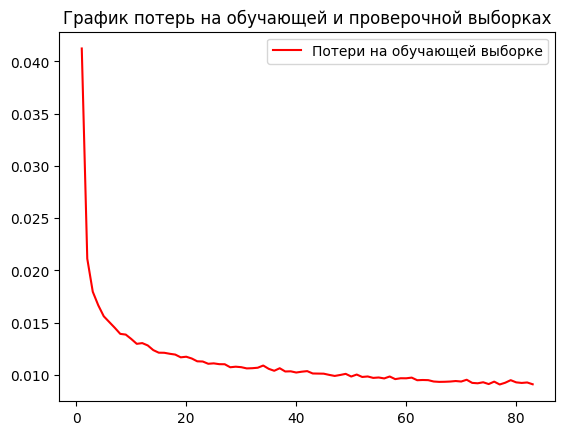

In [ ]:
acc = history.history['acc']              # данные о точности на обучающей выборке
loss = history.history['loss']            # данные об ошибке на обучающей выборке
epochs = range(1, len(acc) + 1)           # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

In [ ]:
result = watermark_auto_encoder.predict(x_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step


Исходное изображение тестовой выборки без водных знаков

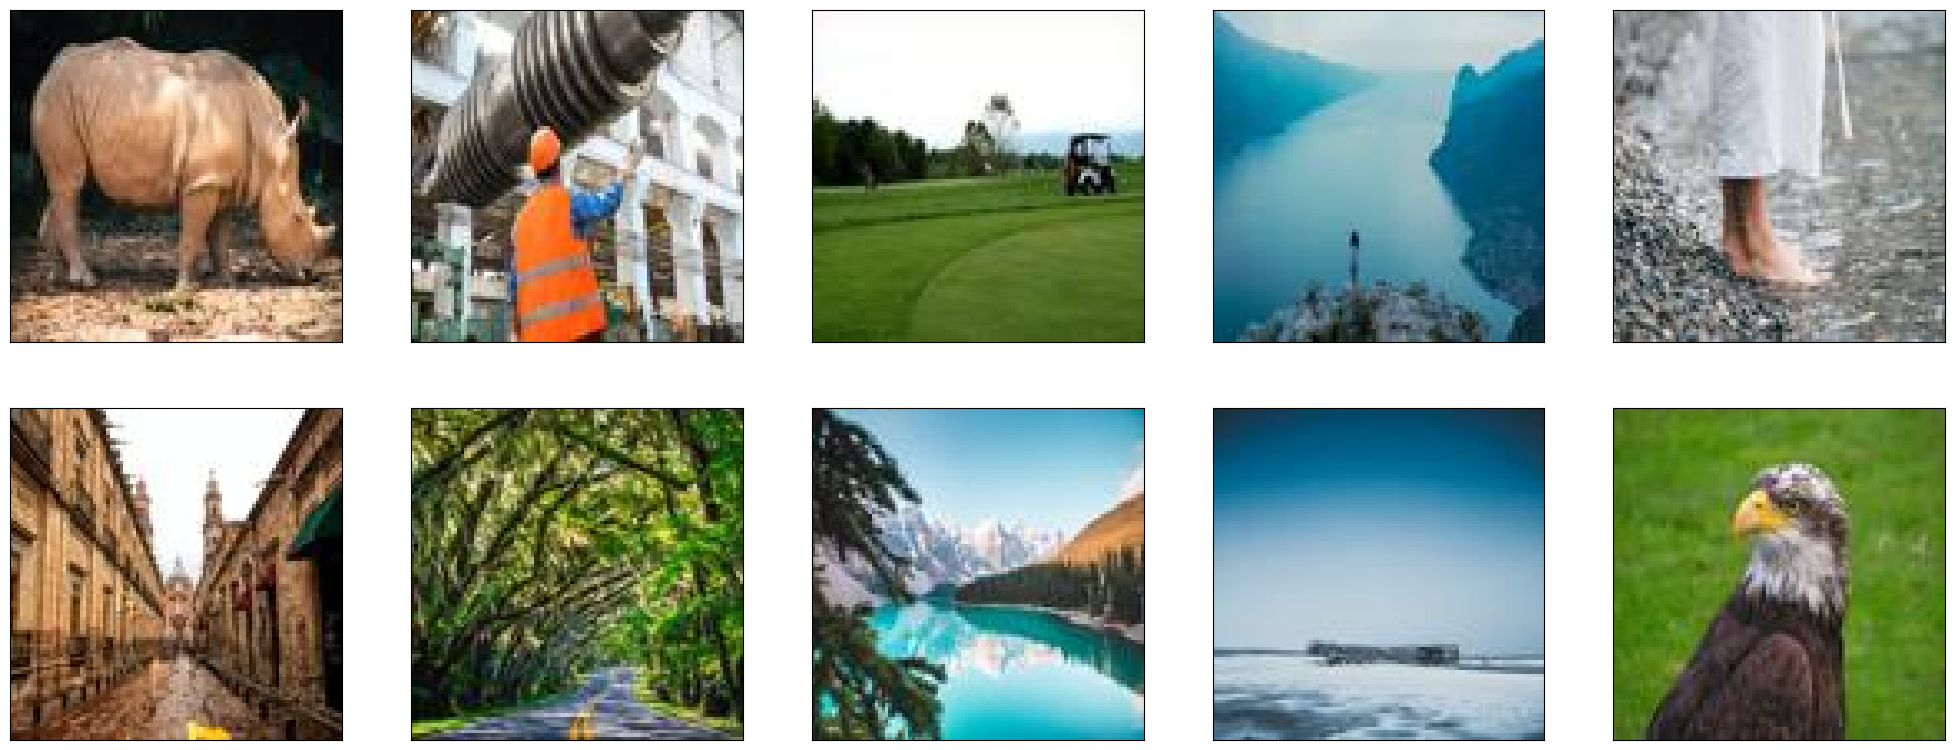

In [ ]:
plt.figure(figsize=(25,25))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(y_test[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()

Изображение тестовой выборки с водными знаками

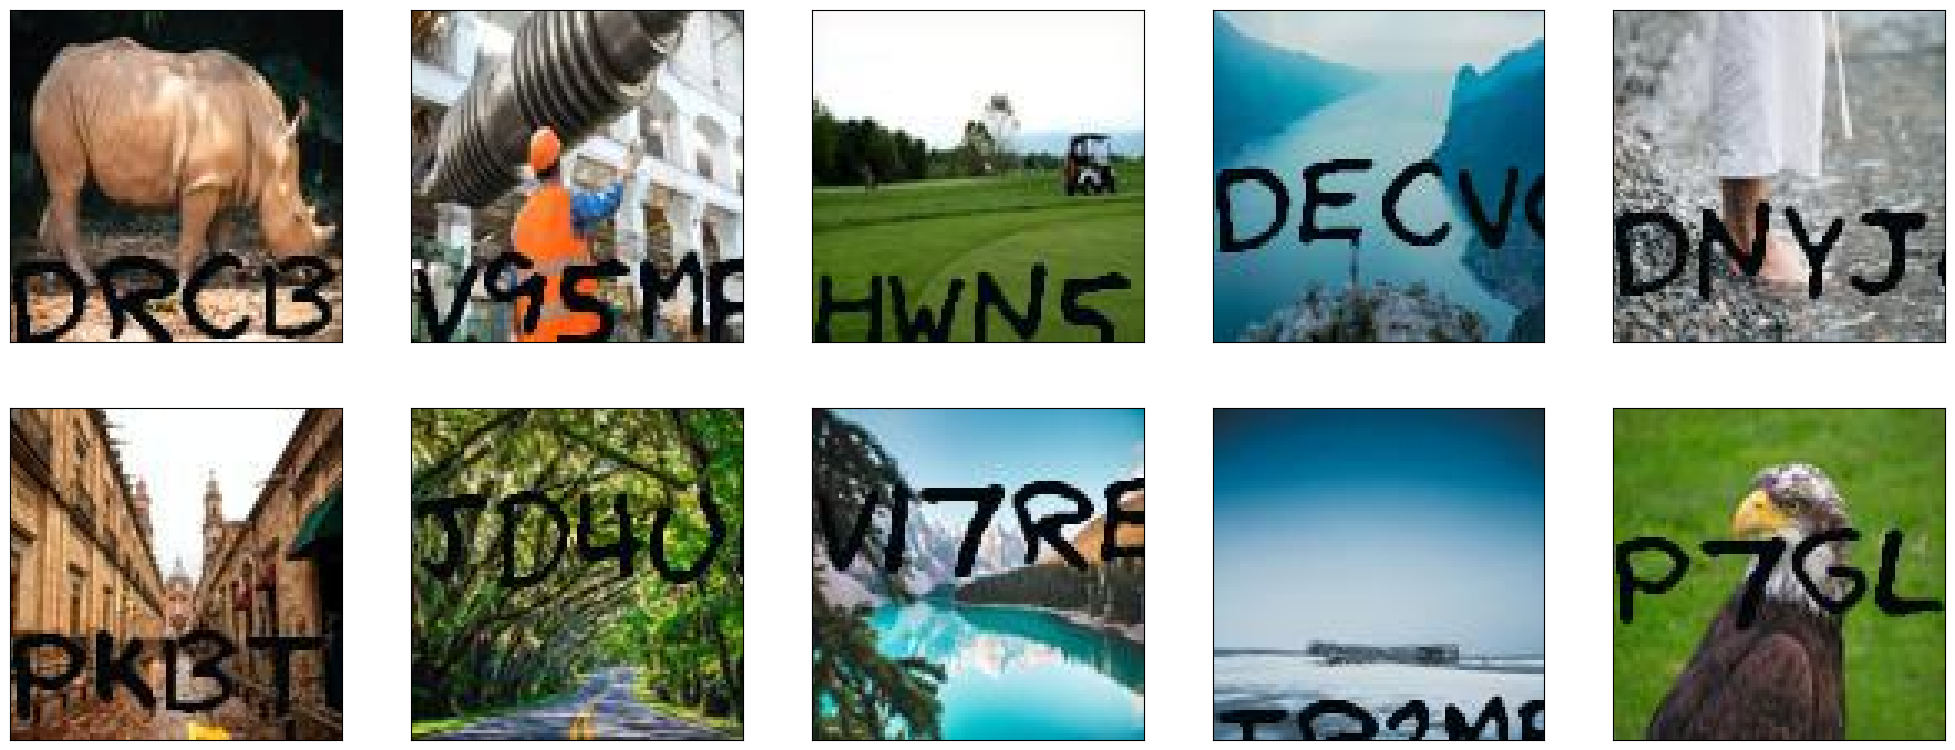

In [ ]:
plt.figure(figsize=(25,25))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(x_test[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()

Предсказанное изображение

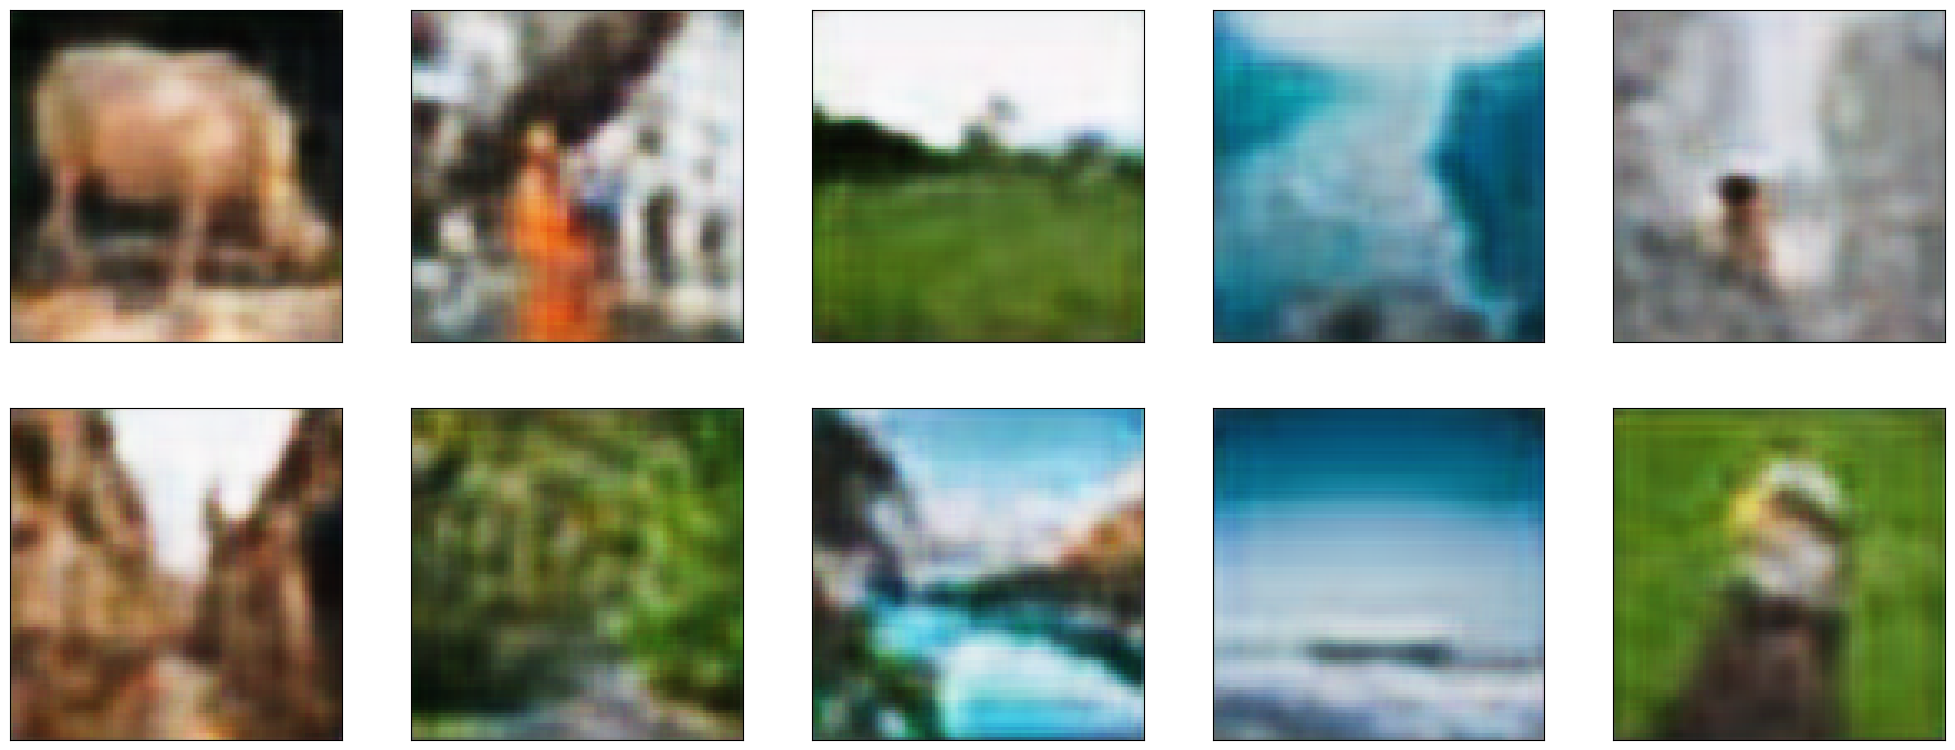

In [ ]:
plt.figure(figsize=(25,25))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(result[i], cv2.COLOR_BGR2RGB))
plt.show()

Изображение шума

In [ ]:
noise = []

for i in range(len(y_test)):
  try:
    temp = y_test[i].astype('float32') - result[i].astype('float32')
    noise.append(temp)
  except Exception as e:
    print(f"Ошибка: {e}")

noise = np.array(noise)

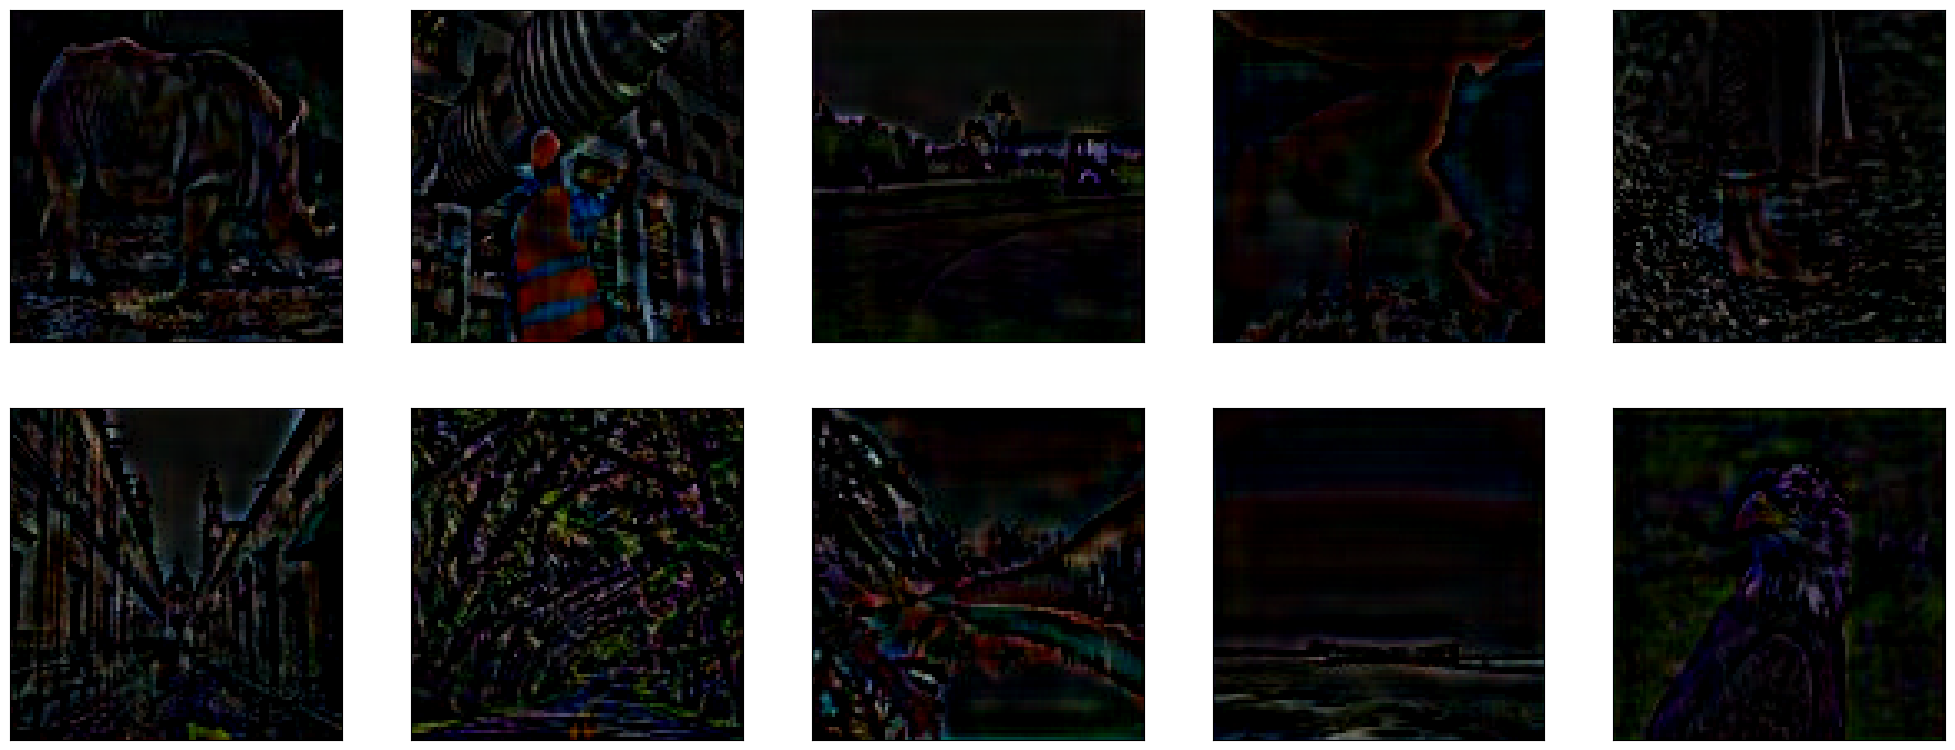

In [ ]:
plt.figure(figsize=(25,25))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(noise[i], cv2.COLOR_BGR2RGB))
plt.show()